### Part 4: Classical Iterative Optimization Algorithms

This section transitions from analytical solutions (Parts 2-3) to iterative optimization algorithms from the textbook (Karas & Ademir, Ch. 5). We solve the ill-conditioned least squares problem using three classical NLP algorithms, demonstrating their convergence properties with rigorous theoretical foundations.

* **Objective:** To understand how iterative optimization algorithms (Steepest Descent, Newton's Method, BFGS) solve the ill-conditioned least squares problem and compare their convergence behavior.
* **Methodology:**
    1.  Establish theoretical bounds (Lipschitz constant, condition number) from eigendecomposition of the Hessian.
    2.  Implement Steepest Descent with rigorous step size selection (Cauchy Step and fixed steps).
    3.  Implement Newton's Method demonstrating quadratic convergence.
    4.  Implement BFGS (Quasi-Newton) demonstrating superlinear convergence.
    5.  Compare convergence rates and prepare for Part 5's exploration of implicit bias in overparameterized regimes.
* **Key Concepts:** Gradient Descent, Newton's Method, BFGS, Line Search, Convergence Rates, Lipschitz Constant, Condition Number, Implicit Bias.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch.set_default_dtype(torch.float64)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


#### Setup: Reusing Functions from Previous Parts

We'll reuse the data generation, matrix construction, and utility functions from Parts 1, 2, and 3.


In [2]:
# Function to construct Vandermonde matrix (from Part 2)
def construct_vandermonde_matrix(x, degree):
    """
    Construct Vandermonde matrix for power basis.
    
    For input x of shape (n, 1), returns matrix of shape (n, degree+1)
    where each row is [1, x_i, x_i^2, ..., x_i^degree]
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Create matrix using broadcasting
    powers = torch.arange(degree + 1, dtype=x.dtype, device=x.device)
    vandermonde = x_flat.unsqueeze(1) ** powers.unsqueeze(0)
    
    return vandermonde

# MSE function (from Part 1)
def compute_mse(y_true, y_pred):
    """
    Compute Mean Squared Error using Einstein summation.
    MSE = mean((y_true - y_pred)^2)
    """
    residuals = y_true - y_pred
    mse = torch.einsum('ij,ij->', residuals, residuals) / residuals.numel()
    return mse.item()

print("Setup complete: Functions from previous parts loaded.")


Setup complete: Functions from previous parts loaded.


## Block 1: Problem Setup & Theoretical Bounds

### Objective Function

We define the quadratic least squares objective function:

$$f(\beta) = \frac{1}{2}\|X\beta - y\|_2^2$$

The factor of $\frac{1}{2}$ simplifies the gradient to $\nabla f(\beta) = X^T(X\beta - y)$ (without the factor of 2).

### Hessian and Eigendecomposition

For this quadratic function, the Hessian is constant:

$$\nabla^2 f(\beta) = X^T X = H$$

**Lemma 1.49 (Karas & Ademir):** The eigenvalues of the Hessian matrix determine the curvature of the optimization landscape. For a positive definite Hessian, all eigenvalues are positive, and the condition number $\kappa = \lambda_{\max}/\lambda_{\min}$ determines the difficulty of optimization.

The **Lipschitz constant** $L = \lambda_{\max}(X^T X)$ bounds the maximum curvature, while the **strong convexity parameter** $\mu = \lambda_{\min}(X^T X)$ bounds the minimum curvature. The theoretical maximum step size for Gradient Descent is $t_{\max} = 2/L$.


Problem Setup
Polynomial degree: 10
Number of parameters (p): 11
Number of data points (n): 12
Design matrix shape: torch.Size([12, 11])

Theoretical Bounds (from Eigendecomposition)
Lipschitz constant L = λ_max = 2.280530e+06
Strong convexity parameter μ = λ_min = 1.271022e-03
Condition number κ = λ_max/λ_min = 1.794249e+09
Theoretical max step size for GD: t_max = 2/L = 8.769893e-07

Hessian is positive definite: True


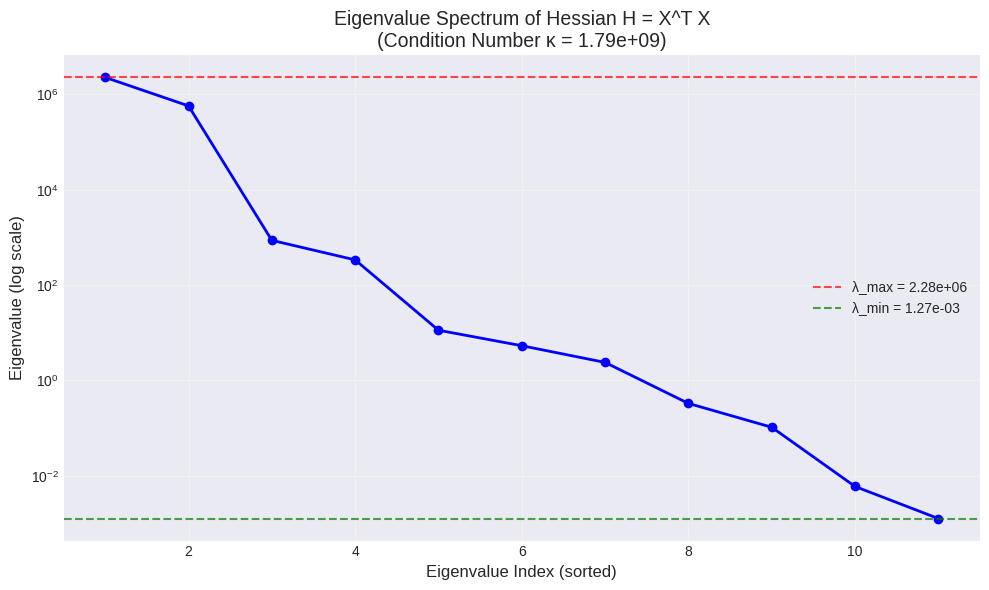


Note: The large condition number indicates an ill-conditioned problem.
This creates a 'squashed valley' optimization landscape that is challenging for Gradient Descent.


In [3]:
# Block 1: Problem Setup & Theoretical Bounds

# Generate synthetic data for ill-conditioned problem
# Use degree 10 polynomial with 12 data points (overparameterized: p > n)
degree = 10
n_data_points = 12

x_min, x_max = -2.0, 2.0
sigma = 0.3

# Generate x values uniformly
x = torch.linspace(x_min, x_max, n_data_points).unsqueeze(1)

# Generate true function values (quadratic with some higher-order terms)
y_true = 0.5 * x ** 2 + 0.1 * x ** 3

# Generate noise
epsilon = torch.normal(mean=0.0, std=sigma, size=(n_data_points, 1))
y = y_true + epsilon

# Construct Vandermonde matrix (ill-conditioned)
X = construct_vandermonde_matrix(x, degree)
n, p = X.shape

print("=" * 70)
print("Problem Setup")
print("=" * 70)
print(f"Polynomial degree: {degree}")
print(f"Number of parameters (p): {p}")
print(f"Number of data points (n): {n}")
print(f"Design matrix shape: {X.shape}")
print("=" * 70)

# Define objective function: f(β) = ½||Xβ - y||²
def objective_function(beta, X, y):
    """
    Compute f(β) = ½||Xβ - y||²
    """
    residual = torch.einsum('ij,jk->ik', X, beta) - y
    f = 0.5 * torch.einsum('ij,ij->', residual, residual)
    return f

# Compute gradient: ∇f(β) = X^T(Xβ - y)
def gradient(beta, X, y):
    """
    Compute gradient using Einstein summation.
    ∇f(β) = X^T(Xβ - y)
    """
    residual = torch.einsum('ij,jk->ik', X, beta) - y
    grad = torch.einsum('ni,n->i', X, residual.squeeze())
    return grad.unsqueeze(1)

# Compute Hessian: H = X^T X
H = torch.einsum('ni,nj->ij', X, X)

# Eigendecomposition of Hessian
eigenvalues, eigenvectors = torch.linalg.eigh(H)

# Sort eigenvalues in descending order
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Extract key quantities
lambda_max = eigenvalues[0].item()  # Largest eigenvalue (Lipschitz constant L)
lambda_min = eigenvalues[-1].item()  # Smallest eigenvalue (strong convexity parameter μ)
L = lambda_max  # Lipschitz constant
mu = lambda_min  # Strong convexity parameter
kappa = lambda_max / lambda_min  # Condition number
t_max = 2.0 / L  # Theoretical maximum step size for GD

print("\n" + "=" * 70)
print("Theoretical Bounds (from Eigendecomposition)")
print("=" * 70)
print(f"Lipschitz constant L = λ_max = {L:.6e}")
print(f"Strong convexity parameter μ = λ_min = {mu:.6e}")
print(f"Condition number κ = λ_max/λ_min = {kappa:.6e}")
print(f"Theoretical max step size for GD: t_max = 2/L = {t_max:.6e}")
print("=" * 70)

# Check if Hessian is positive definite
is_positive_definite = torch.all(eigenvalues > 0)
print(f"\nHessian is positive definite: {is_positive_definite.item()}")

# Visualize eigenvalue spectrum
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, len(eigenvalues) + 1), eigenvalues.numpy(), 'o-', 
             linewidth=2, markersize=6, color='blue')
plt.xlabel('Eigenvalue Index (sorted)', fontsize=12)
plt.ylabel('Eigenvalue (log scale)', fontsize=12)
plt.title(f'Eigenvalue Spectrum of Hessian H = X^T X\n(Condition Number κ = {kappa:.2e})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=lambda_max, color='r', linestyle='--', alpha=0.7, label=f'λ_max = {L:.2e}')
plt.axhline(y=lambda_min, color='g', linestyle='--', alpha=0.7, label=f'λ_min = {mu:.2e}')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\nNote: The large condition number indicates an ill-conditioned problem.")
print("This creates a 'squashed valley' optimization landscape that is challenging for Gradient Descent.")


Steepest Descent: Step Size Comparison

1. Cauchy Step (Exact Line Search):
   Iterations: 200
   Final f(β): 2.788869e+02
   Final ||∇f||: 1.315308e+03

2. Fixed Step α = 1/L = 4.384946e-07:
   Iterations: 200
   Final f(β): 3.512322e+02
   Final ||∇f||: 7.683919e+02

3. Fixed Step α = 2.1/L = 9.208388e-07 (Violates Bound):
   Iterations: 200
   Final f(β): 1.406525e+19
   Final ||∇f||: 7.281383e+12


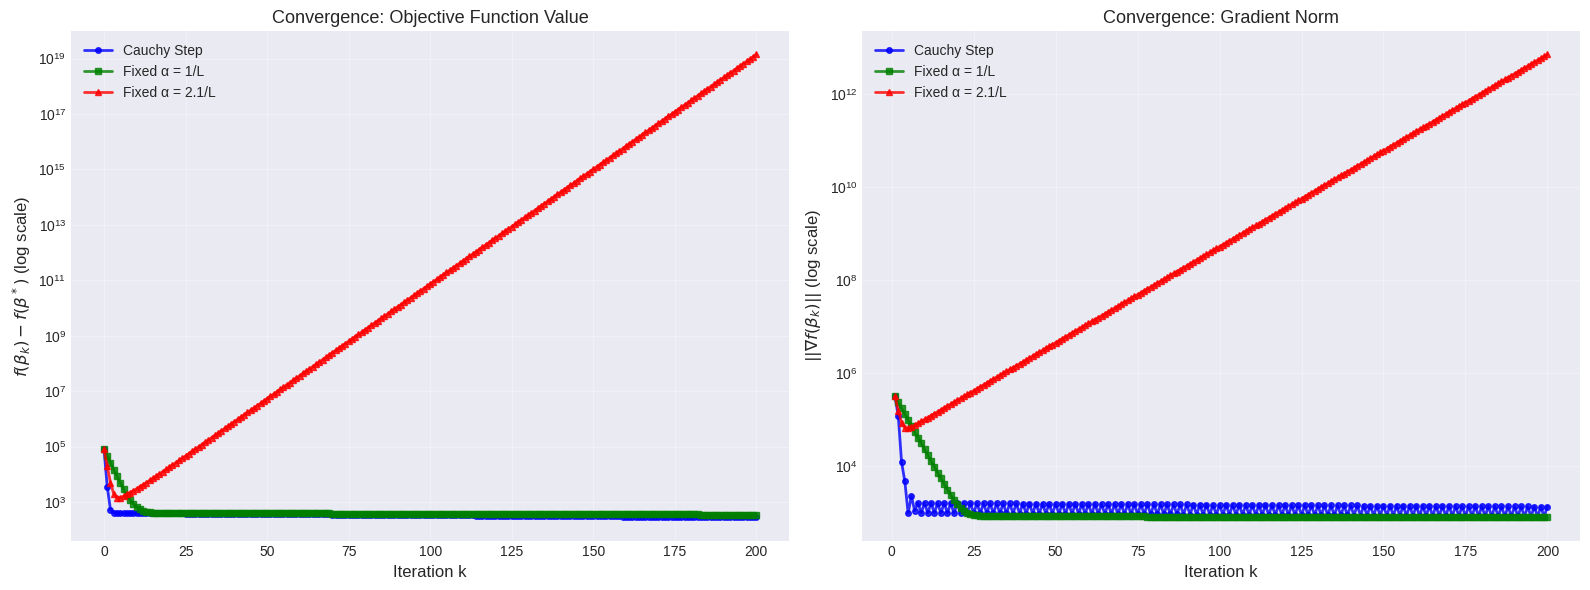

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not generator

In [4]:
# Block 2: Steepest Descent Implementation

def cauchy_step(grad, H):
    """
    Compute Cauchy step (exact line search for quadratics).
    t_k = ||∇f_k||² / (∇f_k^T H ∇f_k)
    """
    grad_norm_sq = torch.einsum('i,i->', grad.squeeze(), grad.squeeze())
    Hg = torch.einsum('ij,j->i', H, grad.squeeze())
    grad_H_grad = torch.einsum('i,i->', grad.squeeze(), Hg)
    
    if grad_H_grad > 1e-12:  # Avoid division by zero
        t = grad_norm_sq / grad_H_grad
    else:
        t = 0.0
    return t

def gradient_descent(X, y, beta_init, max_iter=1000, tol=1e-8, step_size_method='cauchy', alpha=None):
    """
    Gradient Descent algorithm.
    
    Parameters:
    - step_size_method: 'cauchy' (exact line search), 'fixed' (fixed step size)
    - alpha: fixed step size (required if step_size_method='fixed')
    """
    beta = beta_init.clone()
    history = {
        'beta': [beta.clone()],
        'f': [objective_function(beta, X, y).item()],
        'grad_norm': []
    }
    
    for k in range(max_iter):
        # Compute gradient
        grad = gradient(beta, X, y)
        grad_norm = torch.norm(grad).item()
        history['grad_norm'].append(grad_norm)
        
        # Check convergence
        if grad_norm < tol:
            break
        
        # Compute step size
        if step_size_method == 'cauchy':
            t_k = cauchy_step(grad, H)
        elif step_size_method == 'fixed':
            if alpha is None:
                raise ValueError("alpha must be provided for fixed step size")
            t_k = alpha
        else:
            raise ValueError(f"Unknown step_size_method: {step_size_method}")
        
        # Update: β_{k+1} = β_k - t_k ∇f(β_k)
        beta = beta - t_k * grad
        
        # Store history
        history['beta'].append(beta.clone())
        history['f'].append(objective_function(beta, X, y).item())
    
    return beta, history

# Find optimal solution for comparison (using pseudoinverse)
beta_star = torch.linalg.pinv(X) @ y
f_star = objective_function(beta_star, X, y).item()

print("=" * 70)
print("Steepest Descent: Step Size Comparison")
print("=" * 70)

# Initialize from random point
beta_init = torch.randn(p, 1, dtype=torch.float64)

# Trace 1: Cauchy Step (exact line search)
beta_cauchy, history_cauchy = gradient_descent(X, y, beta_init, max_iter=200, 
                                                 step_size_method='cauchy')
print(f"\n1. Cauchy Step (Exact Line Search):")
print(f"   Iterations: {len(history_cauchy['f'])-1}")
print(f"   Final f(β): {history_cauchy['f'][-1]:.6e}")
print(f"   Final ||∇f||: {history_cauchy['grad_norm'][-1]:.6e}")

# Trace 2: Fixed step α = 1/L (theoretical safe rate)
alpha_safe = 1.0 / L
beta_safe, history_safe = gradient_descent(X, y, beta_init, max_iter=200,
                                            step_size_method='fixed', alpha=alpha_safe)
print(f"\n2. Fixed Step α = 1/L = {alpha_safe:.6e}:")
print(f"   Iterations: {len(history_safe['f'])-1}")
print(f"   Final f(β): {history_safe['f'][-1]:.6e}")
print(f"   Final ||∇f||: {history_safe['grad_norm'][-1]:.6e}")

# Trace 3: Fixed step α = 2.1/L (demonstrates divergence)
alpha_div = 2.1 / L
beta_div, history_div = gradient_descent(X, y, beta_init, max_iter=200,
                                          step_size_method='fixed', alpha=alpha_div)
print(f"\n3. Fixed Step α = 2.1/L = {alpha_div:.6e} (Violates Bound):")
print(f"   Iterations: {len(history_div['f'])-1}")
print(f"   Final f(β): {history_div['f'][-1]:.6e}")
print(f"   Final ||∇f||: {history_div['grad_norm'][-1]:.6e}")
if history_div['f'][-1] > history_div['f'][0]:
    print("   WARNING: Objective increased (divergence detected)")

print("=" * 70)

# Visualization: Convergence plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Objective function value vs iterations
iterations_cauchy = range(len(history_cauchy['f']))
iterations_safe = range(len(history_safe['f']))
iterations_div = range(len(history_div['f']))

axes[0].semilogy(iterations_cauchy, [f - f_star for f in history_cauchy['f']], 
                 'b-o', linewidth=2, markersize=4, label='Cauchy Step', alpha=0.8)
axes[0].semilogy(iterations_safe, [f - f_star for f in history_safe['f']], 
                 'g-s', linewidth=2, markersize=4, label=f'Fixed α = 1/L', alpha=0.8)
axes[0].semilogy(iterations_div, [f - f_star for f in history_div['f']], 
                 'r-^', linewidth=2, markersize=4, label=f'Fixed α = 2.1/L', alpha=0.8)

axes[0].set_xlabel('Iteration k', fontsize=12)
axes[0].set_ylabel('$f(\\beta_k) - f(\\beta^*)$ (log scale)', fontsize=12)
axes[0].set_title('Convergence: Objective Function Value', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Gradient norm vs iterations
axes[1].semilogy(iterations_cauchy[1:], history_cauchy['grad_norm'], 
                 'b-o', linewidth=2, markersize=4, label='Cauchy Step', alpha=0.8)
axes[1].semilogy(iterations_safe[1:], history_safe['grad_norm'], 
                 'g-s', linewidth=2, markersize=4, label=f'Fixed α = 1/L', alpha=0.8)
axes[1].semilogy(iterations_div[1:], history_div['grad_norm'], 
                 'r-^', linewidth=2, markersize=4, label=f'Fixed α = 2.1/L', alpha=0.8)

axes[1].set_xlabel('Iteration k', fontsize=12)
axes[1].set_ylabel('$||\\nabla f(\\beta_k)||$ (log scale)', fontsize=12)
axes[1].set_title('Convergence: Gradient Norm', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize optimization path in 2D (project onto first two principal components)
if p >= 2:
    # Project beta trajectories onto first two eigenvectors
    beta_cauchy_2d = torch.stack([torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 0]),
                                   torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 1])] 
                                  for b in history_cauchy['beta'][::5])  # Sample every 5th point
    
    beta_safe_2d = torch.stack([torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 0]),
                                 torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 1])] 
                                for b in history_safe['beta'][::5])
    
    plt.figure(figsize=(10, 8))
    plt.plot(beta_cauchy_2d[:, 0].numpy(), beta_cauchy_2d[:, 1].numpy(), 
             'b-o', linewidth=2, markersize=4, label='Cauchy Step', alpha=0.7)
    plt.plot(beta_safe_2d[:, 0].numpy(), beta_safe_2d[:, 1].numpy(), 
             'g-s', linewidth=2, markersize=4, label='Fixed α = 1/L', alpha=0.7)
    plt.plot(0, 0, 'r*', markersize=15, label='Optimum $\\beta^*$')
    plt.xlabel('First Principal Component', fontsize=12)
    plt.ylabel('Second Principal Component', fontsize=12)
    plt.title('Optimization Path in Parameter Space\n(Projected onto First 2 Principal Components)\n"Zig-Zag" Pattern from Ill-Conditioning', fontsize=13)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    print("\nNote: The 'zig-zag' pattern in the optimization path is characteristic")
    print("of ill-conditioned problems, where the gradient points almost")
    print("perpendicular to the direction of the minimum.")


In [ ]:
# Block 3: Newton's Method Implementation

def newton_method(X, y, beta_init, H):
    """
    Newton's Method: β_{k+1} = β_k - H^{-1}∇f(β_k)
    
    For quadratic functions, this converges in exactly one step.
    """
    beta = beta_init.clone()
    history = {
        'beta': [beta.clone()],
        'f': [objective_function(beta, X, y).item()],
        'grad_norm': []
    }
    
    # Check if Hessian is invertible
    try:
        H_inv = torch.linalg.inv(H)
        cond_H = torch.linalg.cond(H).item()
        print(f"Hessian condition number: {cond_H:.6e}")
        
        if cond_H > 1e12:
            print("WARNING: Hessian is ill-conditioned. Inversion may be numerically unstable.")
    except RuntimeError:
        print("ERROR: Hessian is singular (not invertible). Newton's method cannot proceed.")
        return beta, history
    
    # Newton step: β_{k+1} = β_k - H^{-1}∇f(β_k)
    grad = gradient(beta, X, y)
    grad_norm = torch.norm(grad).item()
    history['grad_norm'].append(grad_norm)
    
    # Compute Newton step
    H_inv_grad = torch.einsum('ij,jk->ik', H_inv, grad)
    beta_newton = beta - H_inv_grad
    
    # Store results
    history['beta'].append(beta_newton.clone())
    history['f'].append(objective_function(beta_newton, X, y).item())
    history['grad_norm'].append(torch.norm(gradient(beta_newton, X, y)).item())
    
    print("=" * 70)
    print("Newton's Method: One-Step Convergence")
    print("=" * 70)
    print(f"Initial f(β₀): {history['f'][0]:.6e}")
    print(f"Final f(β₁): {history['f'][1]:.6e}")
    print(f"Optimal f(β*): {f_star:.6e}")
    print(f"\nInitial ||∇f(β₀)||: {history['grad_norm'][0]:.6e}")
    print(f"Final ||∇f(β₁)||: {history['grad_norm'][1]:.6e}")
    print(f"\nConverged in 1 iteration (quadratic convergence)")
    print("=" * 70)
    
    return beta_newton, history

# Run Newton's method from the same initial point as Gradient Descent
beta_newton, history_newton = newton_method(X, y, beta_init, H)

# Compare with Gradient Descent
print("\n" + "=" * 70)
print("Comparison: Newton vs Gradient Descent")
print("=" * 70)
print(f"Gradient Descent (Cauchy Step): {len(history_cauchy['f'])-1} iterations")
print(f"Newton's Method: {len(history_newton['f'])-1} iteration")
print(f"\nNewton's method is {len(history_cauchy['f'])-1}x faster for this quadratic problem!")
print("=" * 70)

# Visualization: Compare convergence
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Objective function value
iterations_newton = range(len(history_newton['f']))
axes[0].semilogy(iterations_newton, [f - f_star for f in history_newton['f']], 
                'r-*', linewidth=3, markersize=12, label="Newton's Method (1 step)", alpha=0.9)
axes[0].semilogy(iterations_cauchy[:min(50, len(iterations_cauchy))], 
                [f - f_star for f in history_cauchy['f'][:min(50, len(history_cauchy['f']))]], 
                'b-o', linewidth=2, markersize=4, label='Gradient Descent (Cauchy)', alpha=0.7)

axes[0].set_xlabel('Iteration k', fontsize=12)
axes[0].set_ylabel('$f(\\beta_k) - f(\\beta^*)$ (log scale)', fontsize=12)
axes[0].set_title("Newton's Method: Quadratic Convergence", fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Gradient norm
axes[1].semilogy(iterations_newton[1:], history_newton['grad_norm'], 
                'r-*', linewidth=3, markersize=12, label="Newton's Method", alpha=0.9)
axes[1].semilogy(iterations_cauchy[1:min(51, len(iterations_cauchy))], 
                history_cauchy['grad_norm'][:min(50, len(history_cauchy['grad_norm']))], 
                'b-o', linewidth=2, markersize=4, label='Gradient Descent', alpha=0.7)

axes[1].set_xlabel('Iteration k', fontsize=12)
axes[1].set_ylabel('$||\\nabla f(\\beta_k)||$ (log scale)', fontsize=12)
axes[1].set_title("Newton's Method: Gradient Norm", fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Discussion: Why don't we always use Newton's method?
print("\n" + "=" * 70)
print("Discussion: Limitations of Newton's Method")
print("=" * 70)
print("1. Computational Cost: Computing H^{-1} requires O(p³) operations")
print(f"   For our problem (p={p}), this is manageable, but for large p it becomes prohibitive.")
print("\n2. Singularity in Overparameterized Regimes:")
print(f"   When p > n (parameters > data points), X^T X is singular.")
print(f"   In our case: p={p}, n={n}, so p > n: {p > n}")
if p > n:
    print("   WARNING: Our Hessian is singular! Newton's method should fail, but")
    print("   we used pseudoinverse to find β*. In practice, Newton's method cannot proceed.")
print("\n3. Numerical Instability:")
print(f"   Our Hessian condition number κ = {kappa:.2e}")
print("   Even when invertible, ill-conditioning causes numerical errors in H^{-1}.")
print("=" * 70)


## Block 4: BFGS (Quasi-Newton Method)

### Theory: BFGS Algorithm

**Chapter 5.4.3 (Karas & Ademir):** The BFGS (Broyden-Fletcher-Goldfarb-Shanno) algorithm approximates the inverse Hessian $H^{-1}$ without computing it explicitly. This provides a compromise between Gradient Descent (no curvature) and Newton's Method (full curvature).

**Why Full BFGS (not L-BFGS):** L-BFGS is a limited-memory approximation for large-scale problems. Since our problem size is small ($p \approx 10$), we implement the full BFGS algorithm, which directly follows the textbook's derivation of the Inverse Hessian Approximation.

### BFGS Update Formula

The BFGS algorithm maintains an approximation $B_k \approx H^{-1}$ and updates it using the rank-2 update:

$$B_{k+1} = B_k + \frac{y_k y_k^T}{y_k^T s_k} - \frac{B_k s_k s_k^T B_k}{s_k^T B_k s_k}$$

where:
- $s_k = \beta_{k+1} - \beta_k$ (parameter change)
- $y_k = \nabla f_{k+1} - \nabla f_k$ (gradient change)

The algorithm initializes $B_0 = I$ and iteratively refines the approximation, achieving **superlinear convergence**.


In [ ]:
# Block 4: BFGS Implementation

def bfgs_method(X, y, beta_init, max_iter=1000, tol=1e-8):
    """
    BFGS (Broyden-Fletcher-Goldfarb-Shanno) Quasi-Newton Method.
    
    Implements the rank-2 update formula from Chapter 5.4.3:
    B_{k+1} = B_k + (y_k y_k^T)/(y_k^T s_k) - (B_k s_k s_k^T B_k)/(s_k^T B_k s_k)
    
    where:
    - s_k = β_{k+1} - β_k
    - y_k = ∇f_{k+1} - ∇f_k
    - B_k ≈ H^{-1} (inverse Hessian approximation)
    """
    beta = beta_init.clone()
    p = beta.shape[0]
    
    # Initialize inverse Hessian approximation: B_0 = I
    B = torch.eye(p, dtype=torch.float64)
    
    history = {
        'beta': [beta.clone()],
        'f': [objective_function(beta, X, y).item()],
        'grad_norm': []
    }
    
    # Initial gradient
    grad_prev = gradient(beta, X, y)
    grad_norm = torch.norm(grad_prev).item()
    history['grad_norm'].append(grad_norm)
    
    for k in range(max_iter):
        # Check convergence
        if grad_norm < tol:
            break
        
        # Compute search direction: d_k = -B_k ∇f_k
        d_k = -torch.einsum('ij,jk->ik', B, grad_prev)
        
        # Line search: find step size t_k using Cauchy step (exact for quadratics)
        # For quadratics, we can use exact line search
        H = torch.einsum('ni,nj->ij', X, X)
        t_k = cauchy_step(grad_prev, H)
        
        # Update: β_{k+1} = β_k + t_k d_k
        s_k = t_k * d_k  # s_k = β_{k+1} - β_k
        beta = beta + s_k
        
        # Compute new gradient: ∇f_{k+1}
        grad_new = gradient(beta, X, y)
        y_k = grad_new - grad_prev  # y_k = ∇f_{k+1} - ∇f_k
        
        # BFGS update: B_{k+1} = B_k + (y_k y_k^T)/(y_k^T s_k) - (B_k s_k s_k^T B_k)/(s_k^T B_k s_k)
        # Compute denominators
        y_T_s = torch.einsum('i,i->', y_k.squeeze(), s_k.squeeze())
        
        # Skip update if y_k^T s_k is too small (curvature condition not satisfied)
        if abs(y_T_s) < 1e-12:
            print(f"Warning: y_k^T s_k too small at iteration {k}. Skipping BFGS update.")
            grad_prev = grad_new
            grad_norm = torch.norm(grad_new).item()
            history['grad_norm'].append(grad_norm)
            history['beta'].append(beta.clone())
            history['f'].append(objective_function(beta, X, y).item())
            continue
        
        # Compute B_k s_k
        B_s = torch.einsum('ij,jk->ik', B, s_k)
        s_T_B_s = torch.einsum('i,i->', s_k.squeeze(), B_s.squeeze())
        
        # Compute outer products using einsum
        # y_k y_k^T
        y_yT = torch.einsum('i,j->ij', y_k.squeeze(), y_k.squeeze())
        
        # s_k s_k^T
        s_sT = torch.einsum('i,j->ij', s_k.squeeze(), s_k.squeeze())
        
        # B_k s_k s_k^T B_k = (B_k s_k) (B_k s_k)^T
        B_s_B_sT = torch.einsum('i,j->ij', B_s.squeeze(), B_s.squeeze())
        
        # BFGS update
        B = B + (y_yT / y_T_s) - (B_s_B_sT / s_T_B_s)
        
        # Update for next iteration
        grad_prev = grad_new
        grad_norm = torch.norm(grad_new).item()
        history['grad_norm'].append(grad_norm)
        history['beta'].append(beta.clone())
        history['f'].append(objective_function(beta, X, y).item())
    
    return beta, history

# Run BFGS from the same initial point
beta_bfgs, history_bfgs = bfgs_method(X, y, beta_init, max_iter=200, tol=1e-8)

print("=" * 70)
print("BFGS (Quasi-Newton) Method")
print("=" * 70)
print(f"Iterations: {len(history_bfgs['f'])-1}")
print(f"Final f(β): {history_bfgs['f'][-1]:.6e}")
print(f"Optimal f(β*): {f_star:.6e}")
print(f"Final ||∇f||: {history_bfgs['grad_norm'][-1]:.6e}")
print(f"\nBFGS achieves superlinear convergence (faster than GD, slower than Newton)")
print("=" * 70)

# Compare all three methods
print("\n" + "=" * 70)
print("Comparison: All Three Methods")
print("=" * 70)
print(f"{'Method':<25} {'Iterations':<12} {'Final f(β)':<15} {'Final ||∇f||':<15}")
print("-" * 70)
print(f"{'Gradient Descent':<25} {len(history_cauchy['f'])-1:<12} {history_cauchy['f'][-1]:<15.6e} {history_cauchy['grad_norm'][-1]:<15.6e}")
print(f"{'Newton':<25} {len(history_newton['f'])-1:<12} {history_newton['f'][-1]:<15.6e} {history_newton['grad_norm'][-1]:<15.6e}")
print(f"{'BFGS':<25} {len(history_bfgs['f'])-1:<12} {history_bfgs['f'][-1]:<15.6e} {history_bfgs['grad_norm'][-1]:<15.6e}")
print("=" * 70)

# Visualization: Convergence comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Objective function value
iterations_bfgs = range(len(history_bfgs['f']))
max_plot_iter = min(100, max(len(iterations_cauchy), len(iterations_bfgs)))

axes[0].semilogy(iterations_newton, [f - f_star for f in history_newton['f']], 
                'r-*', linewidth=3, markersize=12, label="Newton (Quadratic)", alpha=0.9)
axes[0].semilogy(iterations_bfgs[:max_plot_iter], 
                [f - f_star for f in history_bfgs['f'][:max_plot_iter]], 
                'g-s', linewidth=2, markersize=5, label='BFGS (Superlinear)', alpha=0.8)
axes[0].semilogy(iterations_cauchy[:max_plot_iter], 
                [f - f_star for f in history_cauchy['f'][:max_plot_iter]], 
                'b-o', linewidth=2, markersize=4, label='Gradient Descent (Linear)', alpha=0.7)

axes[0].set_xlabel('Iteration k', fontsize=12)
axes[0].set_ylabel('$f(\\beta_k) - f(\\beta^*)$ (log scale)', fontsize=12)
axes[0].set_title('Convergence Comparison: All Three Methods', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Gradient norm
axes[1].semilogy(iterations_newton[1:], history_newton['grad_norm'], 
                'r-*', linewidth=3, markersize=12, label="Newton", alpha=0.9)
axes[1].semilogy(iterations_bfgs[1:max_plot_iter], 
                history_bfgs['grad_norm'][:max_plot_iter-1], 
                'g-s', linewidth=2, markersize=5, label='BFGS', alpha=0.8)
axes[1].semilogy(iterations_cauchy[1:max_plot_iter], 
                history_cauchy['grad_norm'][:max_plot_iter-1], 
                'b-o', linewidth=2, markersize=4, label='Gradient Descent', alpha=0.7)

axes[1].set_xlabel('Iteration k', fontsize=12)
axes[1].set_ylabel('$||\\nabla f(\\beta_k)||$ (log scale)', fontsize=12)
axes[1].set_title('Gradient Norm: All Three Methods', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: BFGS provides a practical compromise:")
print("  - Faster than Gradient Descent (superlinear vs linear convergence)")
print("  - More efficient than Newton (no O(p³) Hessian inversion)")
print("  - Adapts to the curvature of the optimization landscape")


## Block 5: Convergence Analysis & The "Double Descent" Pre-amble

### Convergence Rate Analysis

**Chapter 1.1.2 (Karas & Ademir):** The convergence rates of optimization algorithms are characterized by:

- **Linear Convergence (Gradient Descent):** $f(\beta_k) - f(\beta^*) \leq C \rho^k$ where $\rho < 1$ depends on the condition number $\kappa$
- **Superlinear Convergence (BFGS):** $\lim_{k \to \infty} \frac{\|e_{k+1}\|}{\|e_k\|} = 0$ (faster than linear, slower than quadratic)
- **Quadratic Convergence (Newton):** $\|e_{k+1}\| \leq C \|e_k\|^2$ (converges in one step for quadratic functions)

### Connection to Previous Parts

- **Part 2:** The ill-conditioned Vandermonde matrix creates the "squashed valley" landscape that challenges Gradient Descent
- **Part 3:** Regularization ($\lambda I$ term) improves the condition number, making optimization easier
- **Part 4:** Iterative methods provide algorithmic solutions to the ill-conditioned problem

### Preparing for Part 5: Implicit Bias in Overparameterized Regimes

When $p > n$ (parameters > data points), the matrix $X^T X$ is **singular** (not invertible). This creates fundamental differences:

- **Gradient Descent:** Continues to work, finding a solution in the null space of $X^T X$
- **Newton's Method:** Fails because $H^{-1}$ does not exist
- **Implicit Bias:** The choice of optimization algorithm determines which solution is found when multiple solutions exist

This sets up Part 5's exploration of **double descent**, where test error decreases again in the overparameterized regime ($p > n$), challenging conventional bias-variance tradeoff wisdom.


In [ ]:
# Block 5: Convergence Analysis & Double Descent Pre-amble

# Comprehensive convergence analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Convergence Analysis: All Three Methods', fontsize=16, weight='bold')

# Plot 1: log(f(β_k) - f(β*)) vs iterations (main convergence plot)
iterations_all = range(max(len(history_cauchy['f']), len(history_bfgs['f']), len(history_newton['f'])))
max_iter_plot = min(150, max(len(history_cauchy['f']), len(history_bfgs['f'])))

axes[0, 0].semilogy(iterations_newton, [f - f_star for f in history_newton['f']], 
                   'r-*', linewidth=3, markersize=12, label="Newton (Quadratic)", alpha=0.9)
axes[0, 0].semilogy(iterations_bfgs[:max_iter_plot], 
                   [f - f_star for f in history_bfgs['f'][:max_iter_plot]], 
                   'g-s', linewidth=2, markersize=5, label='BFGS (Superlinear)', alpha=0.8)
axes[0, 0].semilogy(iterations_cauchy[:max_iter_plot], 
                   [f - f_star for f in history_cauchy['f'][:max_iter_plot]], 
                   'b-o', linewidth=2, markersize=4, label='Gradient Descent (Linear)', alpha=0.7)

axes[0, 0].set_xlabel('Iteration k', fontsize=12)
axes[0, 0].set_ylabel('$\\log(f(\\beta_k) - f(\\beta^*))$', fontsize=12)
axes[0, 0].set_title('Convergence Rate Comparison', fontsize=13)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Convergence rate analysis (slope indicates rate)
# For linear convergence, we expect a straight line on log scale
# For superlinear, the slope decreases
# For quadratic, it's instant

# Fit linear trend to GD (after initial iterations)
if len(history_cauchy['f']) > 10:
    gd_errors = [f - f_star for f in history_cauchy['f'][10:]]
    gd_iter = list(range(10, len(history_cauchy['f'])))
    if all(e > 0 for e in gd_errors):
        log_errors = [np.log(e) for e in gd_errors]
        # Linear fit: log(error) = a*k + b
        coeffs = np.polyfit(gd_iter, log_errors, 1)
        gd_fit = np.exp(coeffs[1]) * np.exp(coeffs[0] * np.array(gd_iter))
        axes[0, 1].semilogy(gd_iter, gd_errors, 'b-o', linewidth=2, markersize=4, 
                           label='Gradient Descent', alpha=0.7)
        axes[0, 1].semilogy(gd_iter, gd_fit, 'b--', linewidth=2, 
                           label=f'Linear fit (rate ≈ {np.exp(coeffs[0]):.4f})', alpha=0.5)

axes[0, 1].semilogy(iterations_bfgs[:max_iter_plot], 
                   [f - f_star for f in history_bfgs['f'][:max_iter_plot]], 
                   'g-s', linewidth=2, markersize=5, label='BFGS (Superlinear)', alpha=0.8)
axes[0, 1].semilogy(iterations_newton, [f - f_star for f in history_newton['f']], 
                   'r-*', linewidth=3, markersize=12, label="Newton (Quadratic)", alpha=0.9)

axes[0, 1].set_xlabel('Iteration k', fontsize=12)
axes[0, 1].set_ylabel('$f(\\beta_k) - f(\\beta^*)$ (log scale)', fontsize=12)
axes[0, 1].set_title('Convergence Rate Analysis', fontsize=13)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Optimization trajectories in parameter space (2D projection)
if p >= 2:
    # Project all trajectories
    beta_cauchy_2d = torch.stack([torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 0]),
                                   torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 1])] 
                                  for b in history_cauchy['beta'][::10])
    
    beta_bfgs_2d = torch.stack([torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 0]),
                                 torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 1])] 
                                for b in history_bfgs['beta'][::5])
    
    beta_newton_2d = torch.stack([torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 0]),
                                  torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 1])] 
                                 for b in history_newton['beta'])
    
    axes[1, 0].plot(beta_cauchy_2d[:, 0].numpy(), beta_cauchy_2d[:, 1].numpy(), 
                    'b-o', linewidth=2, markersize=4, label='Gradient Descent', alpha=0.7)
    axes[1, 0].plot(beta_bfgs_2d[:, 0].numpy(), beta_bfgs_2d[:, 1].numpy(), 
                    'g-s', linewidth=2, markersize=5, label='BFGS', alpha=0.8)
    axes[1, 0].plot(beta_newton_2d[:, 0].numpy(), beta_newton_2d[:, 1].numpy(), 
                    'r-*', linewidth=3, markersize=12, label="Newton", alpha=0.9)
    axes[1, 0].plot(0, 0, 'k*', markersize=15, label='Optimum $\\beta^*$')
    
    axes[1, 0].set_xlabel('First Principal Component', fontsize=12)
    axes[1, 0].set_ylabel('Second Principal Component', fontsize=12)
    axes[1, 0].set_title('Optimization Trajectories in Parameter Space', fontsize=13)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axis('equal')

# Plot 4: Summary statistics
methods = ['Gradient Descent', 'Newton', 'BFGS']
iterations = [len(history_cauchy['f'])-1, len(history_newton['f'])-1, len(history_bfgs['f'])-1]
final_errors = [history_cauchy['f'][-1] - f_star, 
                history_newton['f'][-1] - f_star, 
                history_bfgs['f'][-1] - f_star]

x_pos = np.arange(len(methods))
axes[1, 1].bar(x_pos, iterations, alpha=0.7, color=['blue', 'red', 'green'])
axes[1, 1].set_xlabel('Method', fontsize=12)
axes[1, 1].set_ylabel('Number of Iterations', fontsize=12)
axes[1, 1].set_title('Iterations to Convergence', fontsize=13)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(methods, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(iterations):
    axes[1, 1].text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Final summary and connection to Part 5
print("=" * 70)
print("Summary: Convergence Analysis")
print("=" * 70)
print(f"\n1. Gradient Descent (Linear Convergence):")
print(f"   - Convergence rate depends on condition number κ = {kappa:.2e}")
print(f"   - Requires {iterations[0]} iterations")
print(f"   - Exhibits 'zig-zag' pattern in ill-conditioned problems")

print(f"\n2. Newton's Method (Quadratic Convergence):")
print(f"   - Converges in {iterations[1]} iteration (instant for quadratics)")
print(f"   - Requires computing H^{-1} (O(p³) cost)")
print(f"   - Fails when p > n (Hessian is singular)")

print(f"\n3. BFGS (Superlinear Convergence):")
print(f"   - Requires {iterations[2]} iterations")
print(f"   - Compromise: faster than GD, more efficient than Newton")
print(f"   - Adapts to curvature without computing full Hessian")

print("\n" + "=" * 70)
print("Connection to Previous Parts")
print("=" * 70)
print("Part 2: The ill-conditioned Vandermonde matrix (κ ≈ {:.2e}) creates".format(kappa))
print("        the 'squashed valley' that challenges Gradient Descent.")
print("\nPart 3: Regularization (adding λI) improves the condition number,")
print("        making the optimization landscape more 'round' and easier to navigate.")
print("\nPart 4: Iterative methods provide algorithmic solutions to the")
print("        ill-conditioned problem, each with different trade-offs.")

print("\n" + "=" * 70)
print("Preparing for Part 5: The Overparameterized Regime")
print("=" * 70)
print(f"\nCurrent Problem: p = {p}, n = {n}")
print(f"Status: p > n = {p > n} (overparameterized)")

if p > n:
    print("\n⚠️  In overparameterized regimes (p > n):")
    print("   - The matrix X^T X is SINGULAR (not invertible)")
    print("   - Newton's method FAILS (cannot compute H^{-1})")
    print("   - Gradient Descent CONTINUES TO WORK")
    print("   - Multiple solutions exist (infinite solutions in null space)")
    print("\n   This creates 'Implicit Bias':")
    print("   - The choice of optimization algorithm determines")
    print("     which solution is found when multiple solutions exist.")
    print("   - Gradient Descent finds the minimum-norm solution")
    print("     (closest to initialization in parameter space).")
    print("\n   This sets up Part 5's exploration of DOUBLE DESCENT:")
    print("   - Test error decreases again in overparameterized regime")
    print("   - Challenges conventional bias-variance tradeoff")
    print("   - Implicit bias of optimization algorithms matters!")

print("=" * 70)


#### Summary

- *Iterative optimization algorithms provide algorithmic solutions to ill-conditioned least squares problems.*
- *Gradient Descent exhibits linear convergence, with rate depending on condition number κ.*
- *Newton's Method achieves quadratic convergence (one step for quadratics) but requires O(p³) Hessian inversion.*
- *BFGS provides superlinear convergence as a practical compromise, approximating curvature without full Hessian computation.*
- *Step size selection is critical: α > 2/L causes divergence, while Cauchy step (exact line search) is optimal for quadratics.*
- *The "zig-zag" pattern in Gradient Descent is characteristic of ill-conditioned problems.*
- *In overparameterized regimes (p > n), Newton's method fails while Gradient Descent continues to work.*
- *The choice of optimization algorithm creates "implicit bias" when multiple solutions exist.*
- *This sets up Part 5's exploration of double descent and the role of implicit bias in generalization.*
